In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt 
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [2]:
data = pd.read_csv('mnist_train.csv')
data = data.values


In [3]:
labels = data[:, 0]
data = data[:,1:]

print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


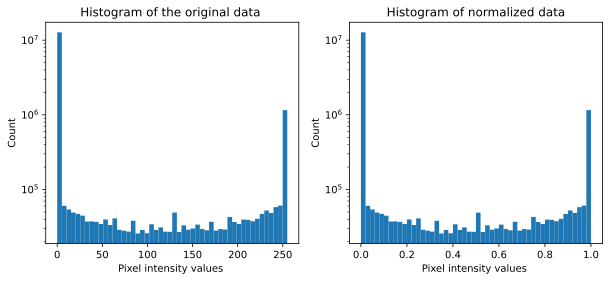

In [4]:
dataNorm = data/np.max(data)

fig, ax = plt.subplots(1,2,figsize = (10,4))
ax[0].hist(data.flatten(), 50)
ax[0].set_xlabel('Pixel intensity values ')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of the original data ')
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(), 50)
ax[1].set_xlabel('Pixel intensity values ')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')

plt.show()

In [5]:
# step 1 : convert to tensor 
dataT = torch.tensor(dataNorm).float()
labels = torch.tensor(labels).long()

# step 2 : splitting the data 
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size = .1)

# step 3 : convert tensor datasets 
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels) 

# step 4 : dataloaders 
train_loader = DataLoader(train_data, batch_size = 32)
test_loader = DataLoader(test_data, batch_size = len(test_data))

In [6]:
%whos

Variable            Type             Data/Info
----------------------------------------------
DataLoader          type             <class 'torch.utils.data.dataloader.DataLoader'>
TensorDataset       type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                  ndarray          2: 2 elems, type `object`, 16 bytes
data                ndarray          20000x784: 15680000 elems, type `int64`, 125440000 bytes (119.62890625 Mb)
dataNorm            ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT               Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
f                   module           <module 'torch.nn.functio<...>orch\\nn\\functional.py'>
fig                 Figure           Figure(1000x400)
labels              Tensor           tensor([1, 0, 1,  ..., 6, 8, 7])
matplotlib_inline   module           <module 'matplotlib_inlin<...>lib_inline\\__init__.py'>
nn                  module      

In [7]:
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()
            

            # input layer 
            self.input = nn.Linear(784, 64)

            # hidden layers
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)

            # output layer 
            self.output = nn.Linear(32, 10)

        def forward(self, X):
            
            X = f.relu(self.input(X))
            X = f.relu(self.fc1(X))
            X = f.relu(self.fc2(X))

            return torch.log_softmax(self.output(X), axis = 1)
        
    # create the model instance 
    net = mnistNet()

    # loss function 
    lossfun = nn.NLLLoss()

    # optimizer 
    optimizer = torch.optim.Adam(net.parameters(), lr = .01)

    return net, lossfun, optimizer 



            
            

In [8]:
# test the model with one batch 
net, lossfun, optimizer = createTheMNISTNet()

X, y = next(iter(train_loader))
yHat = net(X)

# now compute the loss 
loss = lossfun(yHat, y)
print(f'Loss : {loss}')

Loss : 2.2788538932800293


In [9]:
def function2trainTheModel():

    # number of epochs 
    numepochs = 60

    # create a new model 
    net, lossfun, optimizer = createTheMNISTNet()

    # losses 
    losses = np.zeros(numepochs)
    trainAcc = []
    testAcc = []


    for epochi in range(numepochs):
        net.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            yHat = net(X)
            loss = lossfun(yHat, y)
            batchLoss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # matches 
            matches = (torch.argmax(yHat, axis = 1) == y ).float()
            accuracypct = 100*torch.mean(matches)
            batchAcc.append(accuracypct)
        
        losses[epochi] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

        net.eval()
        X, y = next(iter(test_loader))
        with torch.inference_mode():
            yHat = net(X)
            loss = lossfun(yHat, y)
            matches = (torch.argmax(yHat, axis = 1) == y ).float()
            accuracypct = 100*torch.mean(matches)
            testAcc.append(accuracypct)

    return trainAcc, testAcc, losses, net


In [10]:
trainAcc, testAcc, losses, net = function2trainTheModel()

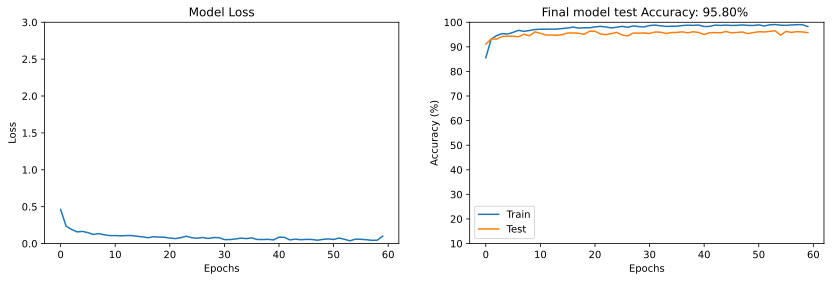

In [11]:
fig, ax = plt.subplots(1,2, figsize = (14,4))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc, label = 'Train')
ax[1].plot(testAcc, label = 'Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test Accuracy: {testAcc[-1]:.2f}% ')
ax[1].legend()

plt.show()

In [12]:
X, y = next(iter(test_loader))
predictions = net(X).detach()

Text(0.5, 1.0, 'True number was 9 ')

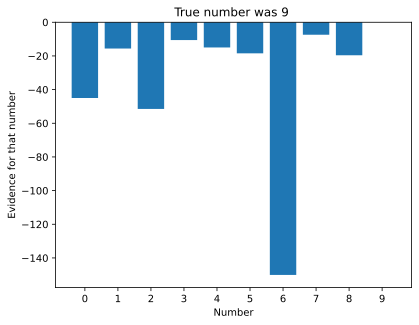

In [13]:
# evidence for all numbers from one sample 
sample2show = 120 

plt.bar(range(10), predictions[sample2show])
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s '%y[sample2show].item())

[   7   63   74   97  110  111  116  130  132  135  165  202  212  255
  272  280  298  346  363  401  411  418  424  425  454  461  520  538
  559  579  594  600  642  653  655  712  717  742  791  797  799  814
  840  874  879  943  978  993 1031 1038 1076 1091 1107 1145 1156 1166
 1185 1205 1260 1281 1298 1355 1378 1386 1451 1479 1514 1546 1570 1604
 1614 1628 1680 1711 1728 1731 1767 1775 1796 1826 1827 1891 1947 1985]


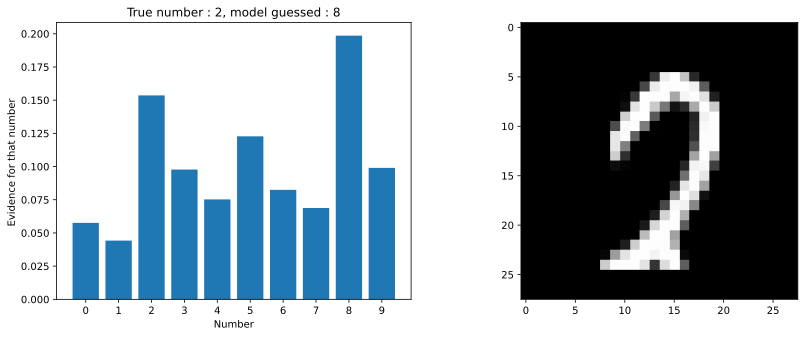

In [14]:
# fint the errors 
errors = np.where(torch.argmax(predictions, axis = 1) != y)[0]
print(errors)

sample2show = 4

fig, ax = plt.subplots(1, 2, figsize = (14,5))

ax[0].bar(range(10), np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number ')
ax[0].set_title(f"True number : {y[errors[sample2show]].item()}, model guessed : {torch.argmax(predictions[errors[sample2show]]).item()}")


ax[1].imshow(np.reshape(X[errors[sample2show], :], (28, 28)), cmap = 'gray')

In [15]:
np.where(torch.argmax(predictions, axis = 1) != y)

(array([   7,   63,   74,   97,  110,  111,  116,  130,  132,  135,  165,
         202,  212,  255,  272,  280,  298,  346,  363,  401,  411,  418,
         424,  425,  454,  461,  520,  538,  559,  579,  594,  600,  642,
         653,  655,  712,  717,  742,  791,  797,  799,  814,  840,  874,
         879,  943,  978,  993, 1031, 1038, 1076, 1091, 1107, 1145, 1156,
        1166, 1185, 1205, 1260, 1281, 1298, 1355, 1378, 1386, 1451, 1479,
        1514, 1546, 1570, 1604, 1614, 1628, 1680, 1711, 1728, 1731, 1767,
        1775, 1796, 1826, 1827, 1891, 1947, 1985], dtype=int64),)